# Parallel Computing with Dask Arrays

This notebook demonstrates parallel computing techniques using Dask, a flexible library for parallel computing in Python. We'll cover:

1. **Introduction to Dask and parallel computing concepts**
2. **Low-level Futures API** for fine-grained control
3. **High-level chunked arrays** for automatic parallelism
4. **Best practices** for Earth science applications
5. **Real-world examples** with climate and geospatial data

## Why Dask?

- **Scales Python**: Works with NumPy, Pandas, and Scikit-learn APIs
- **Out-of-core computation**: Process data larger than memory
- **Task scheduling**: Intelligent parallel task execution
- **Distributed computing**: Scales from laptops to clusters

## Resources
- [Dask Tutorial](https://mybinder.org/v2/gh/dask/dask-tutorial/main?urlpath=lab)
- [Dask Documentation](https://docs.dask.org/en/latest/)
- [Using Dask with xarray](https://docs.xarray.dev/en/latest/user-guide/dask.html)

In [2]:
# Import required libraries
import numpy as np
import dask
import dask.array as da
from dask.distributed import Client, progress
from dask import delayed
import matplotlib.pyplot as plt
import time
from typing import Tuple

# For reproducibility
np.random.seed(42)

## 1. Setting Up the Dask Client

The Dask client provides a dashboard for monitoring computations and manages the cluster of workers.

In [3]:
# Create a local cluster
# n_workers controls parallelism (default: number of cores)
# threads_per_worker: use 1 for CPU-bound tasks, >1 for I/O-bound tasks
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')

# Display client information and dashboard link
print(client)
print(f"\nDashboard available at: {client.dashboard_link}")

<Client: 'tcp://127.0.0.1:56850' processes=4 threads=4, memory=7.45 GiB>

Dashboard available at: http://127.0.0.1:8787/status


---

# Part 1: Low-Level Futures API

The Futures API provides fine-grained control over task execution. Use this when:
- Tasks have complex dependencies
- You need explicit control over task scheduling
- Working with heterogeneous computations

## Example 1: Basic Futures - Parallel Function Execution

In [4]:
def compute_climate_metric(data: np.ndarray, metric: str) -> float:
    """
    Simulate computing a climate metric on data.
    
    Parameters
    ----------
    data : np.ndarray
        Climate data array
    metric : str
        Type of metric to compute
    
    Returns
    -------
    float
        Computed metric value
    """
    time.sleep(0.5)  # Simulate computation time
    
    if metric == 'mean_temp':
        return np.mean(data)
    elif metric == 'std_temp':
        return np.std(data)
    elif metric == 'max_temp':
        return np.max(data)
    elif metric == 'min_temp':
        return np.min(data)
    else:
        return np.median(data)

# Generate synthetic temperature data (e.g., daily temps for a year)
temperature_data = np.random.randn(365) * 10 + 15  # Mean 15°C, std 10°C

# List of metrics to compute
metrics = ['mean_temp', 'std_temp', 'max_temp', 'min_temp', 'median_temp']

### Sequential Execution (Baseline)

In [5]:
%%time
# Sequential execution
sequential_results = {}
for metric in metrics:
    sequential_results[metric] = compute_climate_metric(temperature_data, metric)

print("Sequential Results:")
for metric, value in sequential_results.items():
    print(f"  {metric}: {value:.2f}")

Sequential Results:
  mean_temp: 15.10
  std_temp: 9.47
  max_temp: 53.53
  min_temp: -17.41
  median_temp: 15.58
CPU times: user 94.6 ms, sys: 47.2 ms, total: 142 ms
Wall time: 2.52 s


### Parallel Execution with Futures

In [6]:
%%time
# Submit tasks to the cluster
futures = []
for metric in metrics:
    future = client.submit(compute_climate_metric, temperature_data, metric)
    futures.append((metric, future))

# Gather results
parallel_results = {}
for metric, future in futures:
    parallel_results[metric] = future.result()

print("Parallel Results:")
for metric, value in parallel_results.items():
    print(f"  {metric}: {value:.2f}")

Parallel Results:
  mean_temp: 15.10
  std_temp: 9.47
  max_temp: 53.53
  min_temp: -17.41
  median_temp: 15.58
CPU times: user 55.8 ms, sys: 22.5 ms, total: 78.3 ms
Wall time: 1.03 s


## Example 2: Task Dependencies with Futures

Demonstrate how to build computation graphs with dependencies.

In [7]:
def load_station_data(station_id: int) -> np.ndarray:
    """Simulate loading weather station data."""
    time.sleep(0.3)
    return np.random.randn(100) * 5 + 20 + station_id  # Different mean per station

def preprocess_data(data: np.ndarray) -> np.ndarray:
    """Simulate data preprocessing (quality control, outlier removal)."""
    time.sleep(0.2)
    # Remove outliers beyond 3 standard deviations
    mean, std = np.mean(data), np.std(data)
    mask = np.abs(data - mean) < 3 * std
    return data[mask]

def compute_anomaly(data: np.ndarray, baseline_mean: float) -> np.ndarray:
    """Compute temperature anomaly relative to baseline."""
    time.sleep(0.2)
    return data - baseline_mean

def aggregate_anomalies(anomalies_list: list) -> dict:
    """Aggregate anomalies across all stations."""
    time.sleep(0.1)
    all_anomalies = np.concatenate(anomalies_list)
    return {
        'mean_anomaly': np.mean(all_anomalies),
        'std_anomaly': np.std(all_anomalies),
        'max_anomaly': np.max(all_anomalies)
    }

In [8]:
%%time
# Build a computation graph with dependencies
n_stations = 8
baseline_mean = 20.0  # °C

# Step 1: Load data from all stations (parallel)
load_futures = [client.submit(load_station_data, i) for i in range(n_stations)]

# Step 2: Preprocess each station's data (parallel, depends on load)
preprocess_futures = [client.submit(preprocess_data, fut) for fut in load_futures]

# Step 3: Compute anomalies (parallel, depends on preprocess)
anomaly_futures = [client.submit(compute_anomaly, fut, baseline_mean) 
                   for fut in preprocess_futures]

# Step 4: Aggregate all anomalies (depends on all anomaly computations)
final_result = client.submit(aggregate_anomalies, anomaly_futures)

# Get result
result = final_result.result()
print("Climate Anomaly Analysis:")
for key, value in result.items():
    print(f"  {key}: {value:.3f}°C")

Climate Anomaly Analysis:
  mean_anomaly: 3.585°C
  std_anomaly: 5.518°C
  max_anomaly: 18.764°C
CPU times: user 97.1 ms, sys: 34.8 ms, total: 132 ms
Wall time: 1.56 s


## Best Practice: Using `client.map()` for Batch Operations

In [9]:
%%time
# More elegant approach using map
station_ids = list(range(n_stations))

# Map operations across all inputs
loaded = client.map(load_station_data, station_ids)
preprocessed = client.map(preprocess_data, loaded)
anomalies = client.map(compute_anomaly, preprocessed, baseline_mean=baseline_mean)

# Aggregate
final = client.submit(aggregate_anomalies, anomalies)
result_map = final.result()

print("Results using client.map():")
for key, value in result_map.items():
    print(f"  {key}: {value:.3f}°C")

Results using client.map():
  mean_anomaly: 3.102°C
  std_anomaly: 5.451°C
  max_anomaly: 19.516°C
CPU times: user 88 ms, sys: 31 ms, total: 119 ms
Wall time: 1.57 s


---

# Part 2: High-Level Chunked Arrays

Dask arrays provide a NumPy-like interface with automatic parallelism through chunking. Use this when:
- Working with large arrays that don't fit in memory
- Operations follow standard array patterns
- You want automatic parallelization without explicit task management

## Understanding Chunks

Chunks are the fundamental unit of parallelism in Dask arrays:
- Each chunk is a NumPy array
- Operations are applied to chunks in parallel
- Chunk size affects memory usage and parallelism

In [10]:
# Create a large dask array (simulating a climate dataset)
# Shape: (time, lat, lon) = (365 days, 180 lats, 360 lons)
shape = (365, 180, 360)
chunks = (30, 45, 90)  # Chunk into ~30 day periods, 45° lat, 90° lon blocks

# Generate random temperature data
temperature = da.random.normal(15, 10, size=shape, chunks=chunks)

print(f"Array shape: {temperature.shape}")
print(f"Chunk shape: {temperature.chunks}")
print(f"Number of chunks: {temperature.npartitions}")
print(f"Memory per chunk: ~{temperature.blocks[0, 0, 0].nbytes / 1e6:.2f} MB")
print(f"Total array size: ~{temperature.nbytes / 1e9:.2f} GB")

# Visualize the chunking structure
print(f"\nTask graph has {len(temperature.__dask_graph__())} tasks")

Array shape: (365, 180, 360)
Chunk shape: ((30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 5), (45, 45, 45, 45), (90, 90, 90, 90))
Number of chunks: 208
Memory per chunk: ~0.97 MB
Total array size: ~0.19 GB

Task graph has 208 tasks


## Example 3: Element-wise Operations (Embarrassingly Parallel)

In [11]:
# Element-wise operations are automatically parallelized
# Convert Celsius to Fahrenheit
temp_fahrenheit = temperature * 9/5 + 32

# Compute anomalies from time mean
temp_anomaly = temperature - temperature.mean(axis=0)

# These create lazy computation graphs - no computation yet!
print("Operations defined (lazy evaluation)")
print(f"Task graph size: {len(temp_anomaly.__dask_graph__())} tasks")

Operations defined (lazy evaluation)
Task graph size: 704 tasks


In [12]:
%%time
# Trigger computation with .compute()
anomaly_result = temp_anomaly.compute()

print(f"\nComputed array shape: {anomaly_result.shape}")
print(f"Mean anomaly: {np.mean(anomaly_result):.6f}°C (should be ~0)")
print(f"Std anomaly: {np.std(anomaly_result):.2f}°C")


Computed array shape: (365, 180, 360)
Mean anomaly: -0.000000°C (should be ~0)
Std anomaly: 9.99°C
CPU times: user 263 ms, sys: 222 ms, total: 485 ms
Wall time: 1.36 s


## Example 4: Reduction Operations

Reductions combine data across dimensions and may require communication between chunks.

In [13]:
# Various reduction operations
# These are lazy until computed

# Global statistics
global_mean = temperature.mean()
global_std = temperature.std()

# Spatial average (average over lat/lon for each time step)
spatial_mean = temperature.mean(axis=(1, 2))

# Temporal average (average over time for each location)
temporal_mean = temperature.mean(axis=0)

# Maximum temperature at each location
max_temp = temperature.max(axis=0)

print("Reduction operations defined")
print(f"Spatial mean shape (time series): {spatial_mean.shape}")
print(f"Temporal mean shape (lat x lon): {temporal_mean.shape}")

Reduction operations defined
Spatial mean shape (time series): (365,)
Temporal mean shape (lat x lon): (180, 360)


In [14]:
%%time
# Compute multiple results efficiently
# Using dask.compute() computes multiple arrays in a single pass
gmean, gstd, smean, tmean = dask.compute(global_mean, global_std, 
                                          spatial_mean, temporal_mean)

print("Global Statistics:")
print(f"  Mean temperature: {gmean:.2f}°C")
print(f"  Std temperature: {gstd:.2f}°C")
print(f"\nSpatial mean time series shape: {smean.shape}")
print(f"Temporal mean map shape: {tmean.shape}")

Global Statistics:
  Mean temperature: 15.00°C
  Std temperature: 10.00°C

Spatial mean time series shape: (365,)
Temporal mean map shape: (180, 360)
CPU times: user 257 ms, sys: 41 ms, total: 298 ms
Wall time: 609 ms


## Example 5: Custom Functions with `map_blocks()`

For custom operations not covered by standard array operations.

In [15]:
def custom_quality_control(block: np.ndarray, block_id=None) -> np.ndarray:
    """
    Apply quality control to a data block.
    Replace outliers with NaN.
    
    Parameters
    ----------
    block : np.ndarray
        Input data block
    block_id : tuple, optional
        Block identifier (automatically provided by map_blocks)
    
    Returns
    -------
    np.ndarray
        Quality-controlled data
    """
    # Define physically reasonable temperature range
    min_temp, max_temp = -50, 50  # °C
    
    # Create output array
    result = block.copy()
    
    # Flag outliers
    result[(result < min_temp) | (result > max_temp)] = np.nan
    
    return result

# Apply quality control to all chunks
qc_temperature = temperature.map_blocks(custom_quality_control, dtype=temperature.dtype)

print("Quality control operation defined (lazy)")
print(f"Task graph size: {len(qc_temperature.__dask_graph__())} tasks")

Quality control operation defined (lazy)
Task graph size: 416 tasks


In [16]:
%%time
# Compute statistics on QC'd data
original_mean = temperature.mean().compute()
qc_mean = da.nanmean(qc_temperature).compute()

print(f"Original mean: {original_mean:.2f}°C")
print(f"QC mean: {qc_mean:.2f}°C")
print(f"Difference: {abs(original_mean - qc_mean):.4f}°C")

Original mean: 15.00°C
QC mean: 14.99°C
Difference: 0.0088°C
CPU times: user 401 ms, sys: 61.7 ms, total: 463 ms
Wall time: 903 ms


## Example 6: Working with Real-World Patterns - Time Series Analysis

In [17]:
# Simulate multi-year climate data
# Shape: (10 years * 365 days, 90 lats, 180 lons)
n_years = 10
n_days = 365 * n_years
shape = (n_days, 90, 180)

# Chunk by ~1 year in time, 30° in lat, 60° in lon
chunks = (365, 30, 60)

# Generate data with seasonal cycle + trend
t = da.arange(n_days, chunks=365)[:, None, None]
lat = da.linspace(-90, 90, 90, chunks=30)[None, :, None]
lon = da.linspace(-180, 180, 180, chunks=60)[None, None, :]

# Seasonal cycle (amplitude depends on latitude)
seasonal = 10 * da.cos(lat * np.pi / 180) * da.sin(2 * np.pi * t / 365)

# Long-term trend (global warming)
trend = 0.02 * t / 365  # 0.02°C per year

# Random variability
noise = da.random.normal(0, 2, size=shape, chunks=chunks)

# Combine
climate_data = 15 + seasonal + trend + noise

print(f"Climate dataset shape: {climate_data.shape}")
print(f"Chunks: {climate_data.chunks}")
print(f"Total size: ~{climate_data.nbytes / 1e9:.2f} GB")

Climate dataset shape: (3650, 90, 180)
Chunks: ((365, 365, 365, 365, 365, 365, 365, 365, 365, 365), (30, 30, 30), (60, 60, 60))
Total size: ~0.47 GB


In [18]:
%%time
# Compute climatology (remove seasonal cycle)
# This is a common operation in climate science

# Reshape to (n_years, 365, lat, lon)
reshaped = climate_data.reshape(n_years, 365, 90, 180)

# Compute mean for each day-of-year across all years
climatology = reshaped.mean(axis=0)  # Shape: (365, 90, 180)

# Compute anomalies by broadcasting subtraction
anomalies = reshaped - climatology[None, :, :, :]

# Reshape back to original shape
anomalies = anomalies.reshape(n_days, 90, 180)

# Compute annual mean anomaly (should show the trend)
annual_mean = anomalies.reshape(n_years, 365, 90, 180).mean(axis=(1, 2, 3))

result = annual_mean.compute()

print("Annual mean temperature anomaly (should show warming trend):")
for year, temp in enumerate(result):
    print(f"  Year {year + 1}: {temp:.3f}°C")

Annual mean temperature anomaly (should show warming trend):
  Year 1: -0.090°C
  Year 2: -0.071°C
  Year 3: -0.052°C
  Year 4: -0.029°C
  Year 5: -0.010°C
  Year 6: 0.012°C
  Year 7: 0.030°C
  Year 8: 0.049°C
  Year 9: 0.071°C
  Year 10: 0.090°C
CPU times: user 240 ms, sys: 38.4 ms, total: 278 ms
Wall time: 786 ms


## Example 7: Sliding Window Operations

In [19]:
def moving_average_3d(x: da.Array, window: int, axis: int = 0) -> da.Array:
    """
    Compute moving average along specified axis.
    
    Parameters
    ----------
    x : da.Array
        Input array
    window : int
        Window size
    axis : int
        Axis along which to compute moving average
    
    Returns
    -------
    da.Array
        Smoothed array
    """
    # Use map_overlap for operations that need neighboring chunks
    from dask.array import map_overlap
    
    def _smooth_block(block):
        """Apply moving average to a block."""
        from scipy.ndimage import uniform_filter1d
        return uniform_filter1d(block, size=window, axis=axis, mode='nearest')
    
    # map_overlap handles boundary conditions between chunks
    return map_overlap(
        _smooth_block,
        x,
        depth={axis: window // 2},  # Overlap between chunks
        boundary='nearest',
        dtype=x.dtype
    )

# Apply 30-day moving average
smoothed = moving_average_3d(climate_data, window=30, axis=0)

print("Smoothing operation defined (lazy)")

Smoothing operation defined (lazy)


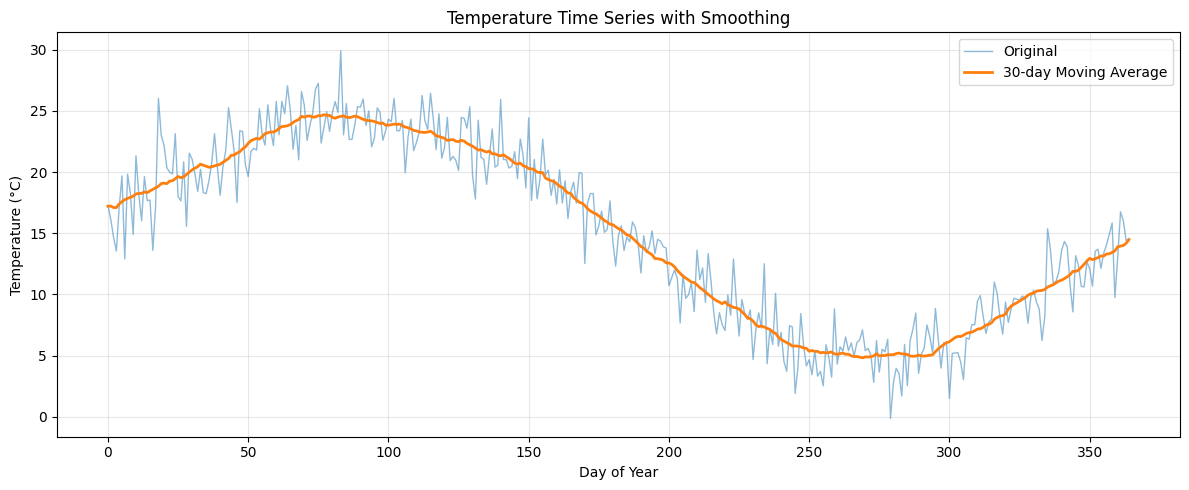

Original variance: 52.00
Smoothed variance: 47.49
CPU times: user 112 ms, sys: 18.4 ms, total: 130 ms
Wall time: 175 ms


In [20]:
%%time
# Extract time series at a specific location
lat_idx, lon_idx = 45, 90  # Mid-latitude location

original_ts = climate_data[:365, lat_idx, lon_idx]
smoothed_ts = smoothed[:365, lat_idx, lon_idx]

orig, smooth = dask.compute(original_ts, smoothed_ts)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(orig, alpha=0.5, label='Original', linewidth=1)
ax.plot(smooth, label='30-day Moving Average', linewidth=2)
ax.set_xlabel('Day of Year')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature Time Series with Smoothing')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Original variance: {np.var(orig):.2f}")
print(f"Smoothed variance: {np.var(smooth):.2f}")

---

# Part 3: Best Practices

## 1. Choosing Chunk Size

In [21]:
def analyze_chunk_size(shape: Tuple[int, ...], dtype=np.float64) -> None:
    """
    Analyze different chunking strategies.
    
    Best practices:
    - Chunk size: 10-100 MB per chunk (sweet spot)
    - Too small: Overhead dominates
    - Too large: Memory issues, poor parallelism
    - Consider access patterns (time series vs spatial maps)
    """
    bytes_per_element = np.dtype(dtype).itemsize
    total_elements = np.prod(shape)
    total_size_gb = total_elements * bytes_per_element / 1e9
    
    print(f"Array shape: {shape}")
    print(f"Total size: {total_size_gb:.2f} GB\n")
    
    # Different chunking strategies
    strategies = {
        'Time slices': (1, shape[1], shape[2]),
        'Temporal blocks': (100, shape[1], shape[2]),
        'Spatial tiles': (shape[0], 30, 60),
        'Balanced 3D': (100, 30, 60),
        'Large chunks': (365, 45, 90),
    }
    
    print(f"{'Strategy':<20} {'Chunk Size':<15} {'# Chunks':<10} {'Chunk MB':<10}")
    print("-" * 60)
    
    for name, chunks in strategies.items():
        chunk_elements = np.prod(chunks)
        chunk_mb = chunk_elements * bytes_per_element / 1e6
        n_chunks = int(np.prod([s // c for s, c in zip(shape, chunks)]))
        
        print(f"{name:<20} {str(chunks):<15} {n_chunks:<10} {chunk_mb:<10.2f}")

# Analyze chunking for our climate dataset
analyze_chunk_size((3650, 90, 180))

Array shape: (3650, 90, 180)
Total size: 0.47 GB

Strategy             Chunk Size      # Chunks   Chunk MB  
------------------------------------------------------------
Time slices          (1, 90, 180)    3650       0.13      
Temporal blocks      (100, 90, 180)  36         12.96     
Spatial tiles        (3650, 30, 60)  9          52.56     
Balanced 3D          (100, 30, 60)   324        1.44      
Large chunks         (365, 45, 90)   40         11.83     


## 2. Avoiding Common Pitfalls

In [22]:
# PITFALL 1: Creating too many tasks
print("PITFALL 1: Too many small chunks\n")

# Bad: 1 element per chunk (massive overhead)
bad = da.ones((1000, 1000), chunks=(1, 1))
print(f"Bad chunking: {bad.npartitions:,} chunks")

# Good: Reasonable chunk size
good = da.ones((1000, 1000), chunks=(100, 100))
print(f"Good chunking: {good.npartitions:,} chunks\n")

# PITFALL 2: Unbalanced chunks after slicing
print("PITFALL 2: Unbalanced chunks after operations\n")

x = da.ones((1000, 1000), chunks=(100, 100))
# Taking a slice can create unbalanced chunks
y = x[:105, :105]  # Creates some small chunks
print(f"After slicing - chunks: {y.chunks}")

# Fix with rechunk
y_fixed = y.rechunk((100, 100))
print(f"After rechunking: {y_fixed.chunks}\n")

# PITFALL 3: Computing intermediate results unnecessarily
print("PITFALL 3: Unnecessary intermediate .compute() calls\n")

# Bad: Multiple compute calls
print("Bad approach:")
start = time.time()
mean1 = temperature.mean().compute()
std1 = temperature.std().compute()
max1 = temperature.max().compute()
bad_time = time.time() - start
print(f"  Time: {bad_time:.3f}s (data processed 3 times)\n")

# Good: Single compute call
print("Good approach:")
start = time.time()
mean2, std2, max2 = dask.compute(temperature.mean(), temperature.std(), temperature.max())
good_time = time.time() - start
print(f"  Time: {good_time:.3f}s (data processed once)")
print(f"  Speedup: {bad_time/good_time:.2f}x")

PITFALL 1: Too many small chunks

Bad chunking: 1,000,000 chunks
Good chunking: 100 chunks

PITFALL 2: Unbalanced chunks after operations

After slicing - chunks: ((100, 5), (100, 5))
After rechunking: ((100, 5), (100, 5))

PITFALL 3: Unnecessary intermediate .compute() calls

Bad approach:
  Time: 1.208s (data processed 3 times)

Good approach:
  Time: 0.530s (data processed once)
  Speedup: 2.28x


## 3. Memory Management

In [23]:
# Monitor memory usage during computation
print("Memory Management Tips:\n")

# 1. Use persist() for intermediate results you'll reuse
print("1. Using persist() for repeated access:")
large_array = da.random.random((10000, 10000), chunks=(1000, 1000))

# Without persist - recomputes every time
result1 = large_array.mean()
result2 = large_array.std()

# With persist - computes once, keeps in distributed memory
persisted = large_array.persist()
result1 = persisted.mean()
result2 = persisted.std()
print("  persist() keeps results in distributed memory for reuse\n")

# 2. Use to_zarr() for very large results
print("2. Saving large results to disk with zarr:")
print("  result.to_zarr('output.zarr') avoids loading all data into memory\n")

# 3. Free memory explicitly
print("3. Clean up when done:")
del persisted
client.cancel(large_array)
print("  Use del and client.cancel() to free memory\n")

# 4. Monitor memory
print("4. Monitor dashboard:")
print(f"  Dashboard: {client.dashboard_link}")
print("  Watch: Task Stream, Memory, Workers tabs")

Memory Management Tips:

1. Using persist() for repeated access:
  persist() keeps results in distributed memory for reuse

2. Saving large results to disk with zarr:
  result.to_zarr('output.zarr') avoids loading all data into memory

3. Clean up when done:
  Use del and client.cancel() to free memory

4. Monitor dashboard:
  Dashboard: http://127.0.0.1:8787/status
  Watch: Task Stream, Memory, Workers tabs


## 4. When to Use Dask Arrays vs Futures

**Use Dask Arrays when:**
- Working with large n-dimensional arrays
- Operations follow standard array patterns (element-wise, reductions)
- Data doesn't fit in memory
- You want automatic optimization

**Use Futures when:**
- Complex control flow and dependencies
- Heterogeneous tasks (different functions, arguments)
- Need explicit task management
- Working with non-array data structures

**Combine both:**
- Use arrays for data processing, futures for workflow orchestration

---

# Part 4: Complete Real-World Example

## Climate Data Analysis Pipeline

Combining futures and arrays for a complete analysis.

In [24]:
def climate_analysis_pipeline(
    data: da.Array,
    anomaly_threshold: float = 2.0
) -> dict:
    """
    Complete climate analysis pipeline.
    
    Steps:
    1. Compute temporal statistics
    2. Identify extreme events
    3. Compute spatial patterns
    4. Generate summary statistics
    
    Parameters
    ----------
    data : da.Array
        Climate data (time, lat, lon)
    anomaly_threshold : float
        Threshold for extreme event detection (std deviations)
    
    Returns
    -------
    dict
        Analysis results
    """
    # 1. Temporal statistics
    time_mean = data.mean(axis=0)
    time_std = data.std(axis=0)
    
    # 2. Compute anomalies
    anomalies = (data - time_mean) / time_std
    
    # 3. Identify extreme events
    extreme_mask = da.abs(anomalies) > anomaly_threshold
    extreme_count = extreme_mask.sum(axis=0)
    
    # 4. Spatial patterns
    spatial_mean = data.mean(axis=(1, 2))  # Time series of global mean
    
    # 5. Summary statistics
    global_mean = data.mean()
    global_std = data.std()
    global_max = data.max()
    global_min = data.min()
    
    return {
        'time_mean': time_mean,
        'time_std': time_std,
        'extreme_count': extreme_count,
        'spatial_mean': spatial_mean,
        'global_stats': (global_mean, global_std, global_max, global_min)
    }

# Run the pipeline
print("Running climate analysis pipeline...")
results = climate_analysis_pipeline(climate_data[:365, :, :])

print("Pipeline defined (lazy computation)")
print(f"Task graph contains operations on {climate_data.shape} array")

Running climate analysis pipeline...
Pipeline defined (lazy computation)
Task graph contains operations on (3650, 90, 180) array


In [25]:
%%time
# Execute pipeline with progress tracking
with dask.config.set(scheduler='threads'):
    # Compute all results
    time_mean, time_std, extreme_count, spatial_mean, global_stats = dask.compute(
        results['time_mean'],
        results['time_std'],
        results['extreme_count'],
        results['spatial_mean'],
        results['global_stats']
    )

gmean, gstd, gmax, gmin = global_stats

print("\n" + "="*60)
print("CLIMATE ANALYSIS RESULTS")
print("="*60)
print(f"\nGlobal Statistics:")
print(f"  Mean temperature: {gmean:.2f}°C")
print(f"  Std temperature: {gstd:.2f}°C")
print(f"  Max temperature: {gmax:.2f}°C")
print(f"  Min temperature: {gmin:.2f}°C")
print(f"\nExtreme Events:")
print(f"  Total extreme events detected: {extreme_count.sum():.0f}")
print(f"  Max extreme events at one location: {extreme_count.max():.0f}")
print(f"\nTemporal mean field shape: {time_mean.shape}")
print(f"Global mean time series length: {len(spatial_mean)}")


CLIMATE ANALYSIS RESULTS

Global Statistics:
  Mean temperature: 15.01°C
  Std temperature: 5.36°C
  Max temperature: 33.43°C
  Min temperature: -3.59°C

Extreme Events:
  Total extreme events detected: 98542
  Max extreme events at one location: 27

Temporal mean field shape: (90, 180)
Global mean time series length: 365
CPU times: user 178 ms, sys: 60.8 ms, total: 239 ms
Wall time: 61.4 ms


## Visualization of Results

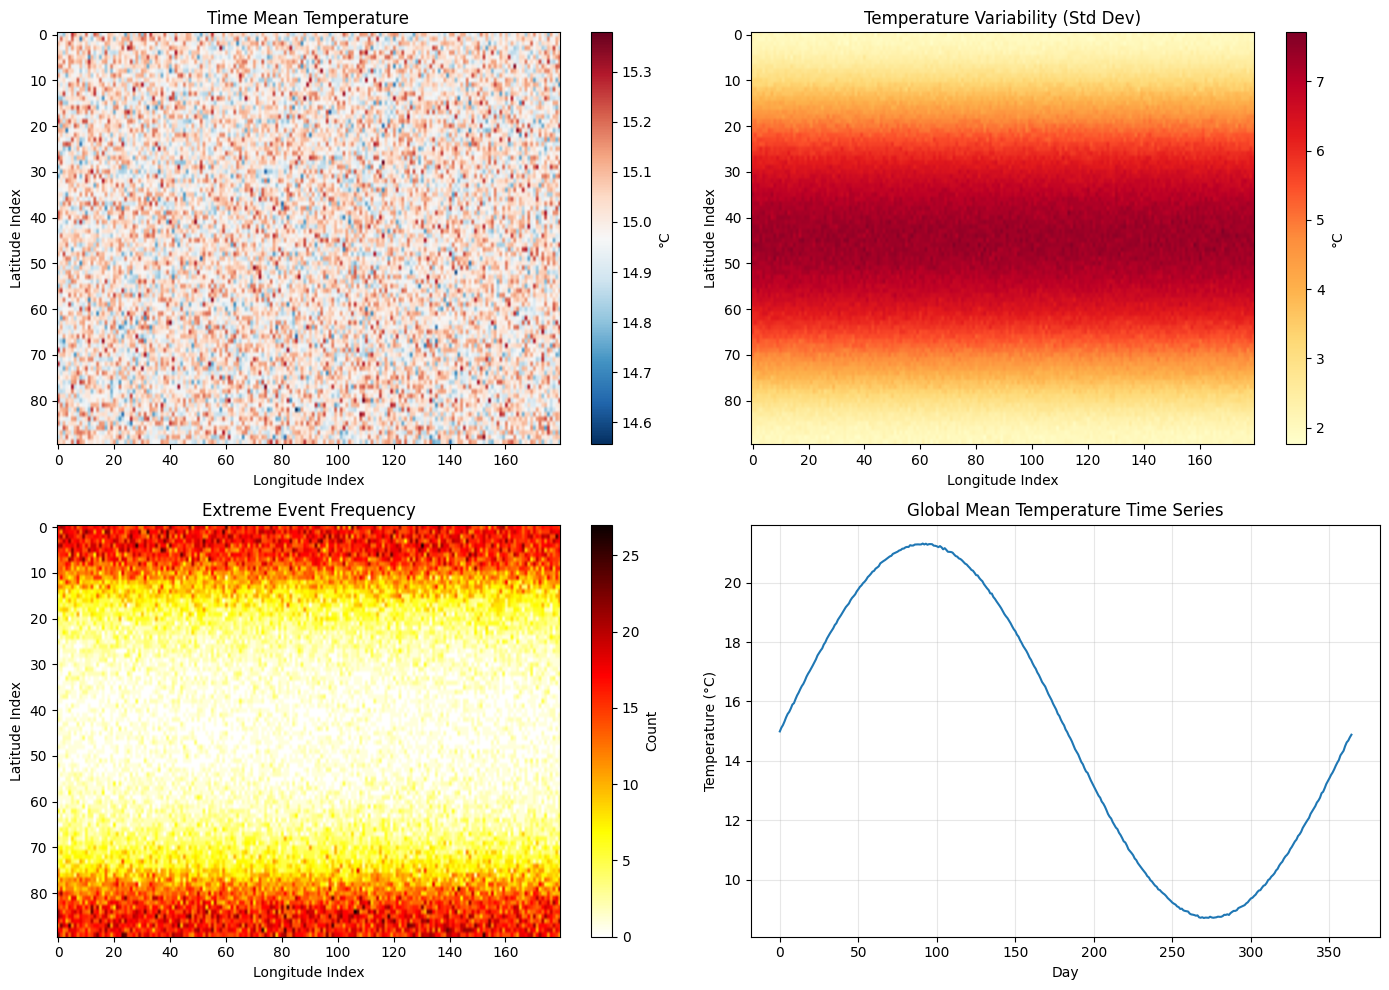

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Time mean temperature
im1 = axes[0, 0].imshow(time_mean, aspect='auto', cmap='RdBu_r')
axes[0, 0].set_title('Time Mean Temperature')
axes[0, 0].set_xlabel('Longitude Index')
axes[0, 0].set_ylabel('Latitude Index')
plt.colorbar(im1, ax=axes[0, 0], label='°C')

# 2. Temporal standard deviation
im2 = axes[0, 1].imshow(time_std, aspect='auto', cmap='YlOrRd')
axes[0, 1].set_title('Temperature Variability (Std Dev)')
axes[0, 1].set_xlabel('Longitude Index')
axes[0, 1].set_ylabel('Latitude Index')
plt.colorbar(im2, ax=axes[0, 1], label='°C')

# 3. Extreme event frequency
im3 = axes[1, 0].imshow(extreme_count, aspect='auto', cmap='hot_r')
axes[1, 0].set_title('Extreme Event Frequency')
axes[1, 0].set_xlabel('Longitude Index')
axes[1, 0].set_ylabel('Latitude Index')
plt.colorbar(im3, ax=axes[1, 0], label='Count')

# 4. Global mean time series
axes[1, 1].plot(spatial_mean, linewidth=1.5)
axes[1, 1].set_title('Global Mean Temperature Time Series')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Clean up
client.close()